Epoch 1/30 - Loss: 4.1607
Epoch 2/30 - Loss: 0.4758
Epoch 3/30 - Loss: 0.1658
Epoch 4/30 - Loss: 0.1149
Epoch 5/30 - Loss: 0.0992
Epoch 6/30 - Loss: 0.0898
Epoch 7/30 - Loss: 0.0828
Epoch 8/30 - Loss: 0.0769
Epoch 9/30 - Loss: 0.0721
Epoch 10/30 - Loss: 0.0680
Epoch 11/30 - Loss: 0.0641
Epoch 12/30 - Loss: 0.0614
Epoch 13/30 - Loss: 0.0585
Epoch 14/30 - Loss: 0.0566
Epoch 15/30 - Loss: 0.0549
Epoch 16/30 - Loss: 0.0518
Epoch 17/30 - Loss: 0.0498
Epoch 18/30 - Loss: 0.0483
Epoch 19/30 - Loss: 0.0464
Epoch 20/30 - Loss: 0.0452
Epoch 21/30 - Loss: 0.0458
Epoch 22/30 - Loss: 0.0426
Epoch 23/30 - Loss: 0.0416
Epoch 24/30 - Loss: 0.0409
Epoch 25/30 - Loss: 0.0400
Epoch 26/30 - Loss: 0.0391
Epoch 27/30 - Loss: 0.0398
Epoch 28/30 - Loss: 0.0376
Epoch 29/30 - Loss: 0.0369
Epoch 30/30 - Loss: 0.0364
✅ Model zapisano do: autoencoder.pth


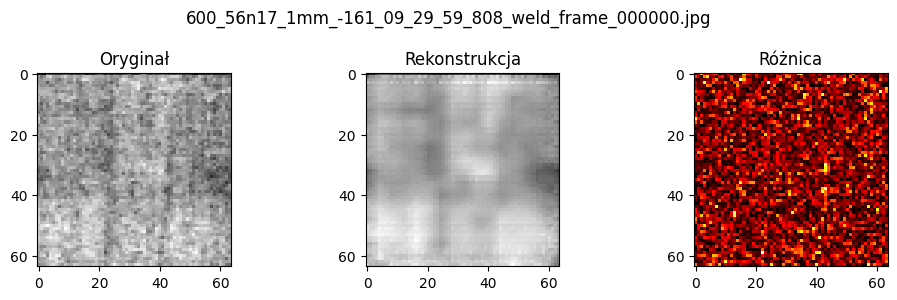

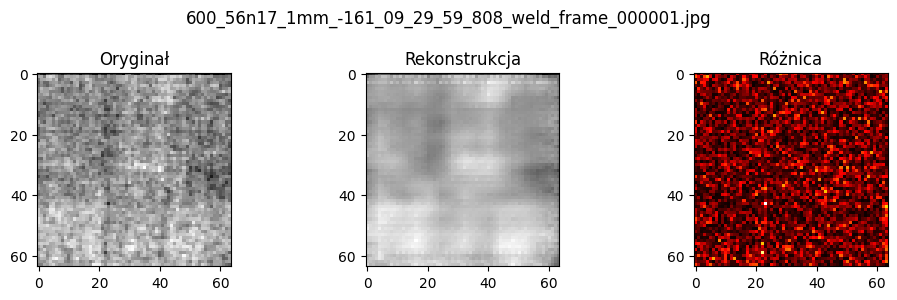

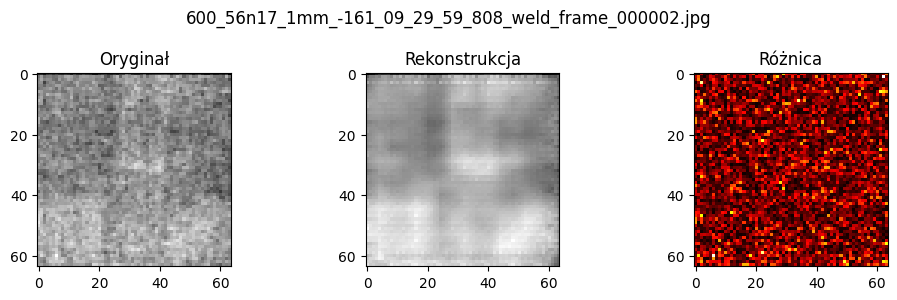

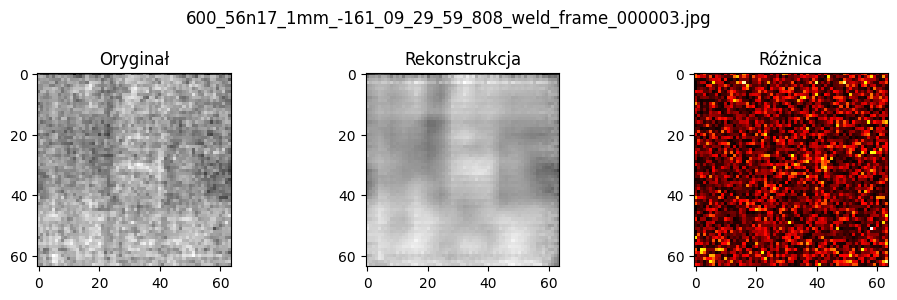

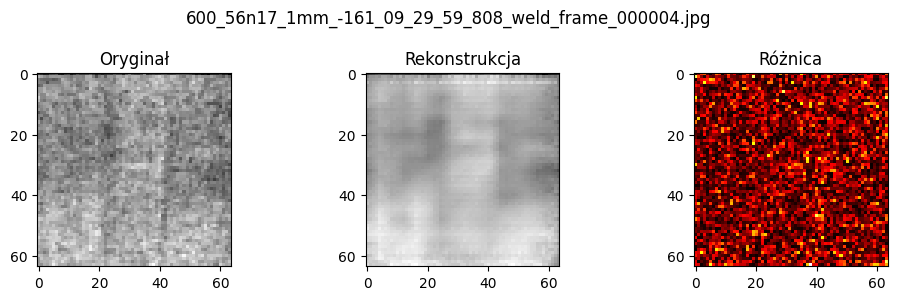

In [1]:
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# === KONFIGURACJA ===
IMAGE_DIR = "output_rois/train_roi_weld"
MODEL_SAVE_PATH = "autoencoder.pth"
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 16
EPOCHS = 30
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# === TRANSFORMACJE ===
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()  # Zakres [0, 1]
])

# === DATASET ===
class WeldDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.files = sorted(glob.glob(os.path.join(folder, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.files[idx])

dataset = WeldDataset(IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# === AUTOENCODER ===
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = ConvAutoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === TRENING ===
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(DEVICE)
        recon = model(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f}")

# === ZAPIS MODELU ===
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"✅ Model zapisano do: {MODEL_SAVE_PATH}")

# === PODGLĄD REKONSTRUKCJI ===
model.eval()
with torch.no_grad():
    for i in range(5):  # przykładowe 5 obrazów
        img, fname = dataset[i]
        img_tensor = img.unsqueeze(0).to(DEVICE)
        recon = model(img_tensor).cpu().squeeze()

        diff = torch.abs(img.squeeze() - recon)

        plt.figure(figsize=(10, 3))
        plt.suptitle(fname)
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title("Oryginał")
        plt.subplot(1, 3, 2)
        plt.imshow(recon, cmap='gray')
        plt.title("Rekonstrukcja")
        plt.subplot(1, 3, 3)
        plt.imshow(diff, cmap='hot')
        plt.title("Różnica")
        plt.tight_layout()
        plt.show()
